In [1]:
from langchain_qdrant import QdrantVectorStore, FastEmbedSparse
from qdrant_client import QdrantClient
from dotenv import load_dotenv
import os
from langchain_huggingface import HuggingFaceEmbeddings

from langchain_community.tools import WikipediaQueryRun
from langchain_tavily import TavilySearch
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_tavily import TavilySearch
from langchain_core.tools import Tool
from langchain_core.vectorstores.base import VectorStoreRetriever
from langchain.agents import create_agent
from langchain_core.prompts import ChatPromptTemplate
from langgraph.prebuilt import ToolNode, tools_condition


from dataclasses import dataclass
from pydantic import BaseModel, Field
# from typing import List
from langchain_core.documents import Document

from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from langgraph_supervisor import create_supervisor
from IPython.display import display, Image
from typing import List, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from pprint import pprint
load_dotenv()

from langgraph.checkpoint.memory import MemorySaver


c:\RAG\PersistentMemory_CAG\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ProcessLoader:

    def __init__(self):
        self.client = QdrantClient(
                            url=os.getenv('QDRANT_API_URL'),
                            api_key=os.getenv('QDRANT_API_KEY')
                        )
        self.dense_embedding = HuggingFaceEmbeddings(model = 'sentence-transformers/all-MiniLM-L12-v2')
        self.sparse_embedding = FastEmbedSparse(model_name ='Qdrant/bm25')
        
        self.qdrantdb = QdrantVectorStore(
            client=self.client,
            collection_name= os.getenv('COLLECTIONNAME'),
            embedding=self.dense_embedding,
            sparse_embedding=self.sparse_embedding
        )
        self.wiki_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(top_k_results= 5, doc_content_chars_max= 2000))
        self.tavily_tool = TavilySearch(
            max_results=5,
            topic="general",
        )

    @property
    def getPBIRetriver(self):

        return self.qdrantdb.as_retriever(
            search_type = 'mmr',
                search_kwarg = {
                    "k":10
                }
        )
    
    @property
    def wikiTool(self):
        return self.wiki_tool
    
    @property
    def tavilyTool(self):
        return self.tavily_tool
    
    @property
    def getllm(self):
        return ChatGroq(model='openai/gpt-oss-120b')
    
    


In [3]:
obj = ProcessLoader()
pbiretriever = obj.getPBIRetriver

def powerBITool(query: str) -> str:
    
    result = pbiretriever.invoke(query)
    return '\n\n'.join([doc.page_content for doc in result])

    

pbitool = Tool(
    func= powerBITool,
    name="PBI_Triver",
    description= "Tool is created to retrive Power BI docs from Qdrant"
    
)

In [4]:

llm_base = obj.getllm
wikitool = obj.wikiTool
tavilytool = obj.tavilyTool
tools = [wikitool, tavilytool, pbitool]

In [5]:
llm = ChatGroq(model = "openai/gpt-oss-120b")
llm_bind = llm.bind_tools(tools)




In [6]:
@dataclass
class MyAPIBot:
    messages: Annotated[List[AnyMessage],add_messages]

In [7]:
def llm_tools(state: MyAPIBot):

    return {"messages": llm_bind.invoke(state.messages)}

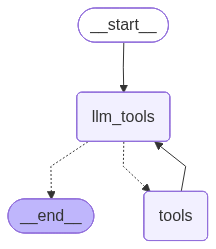

In [8]:
graph = StateGraph(MyAPIBot)

graph.add_node("llm_tools", llm_tools)
graph.add_node("tools", ToolNode(tools=tools))

graph.add_edge(START,"llm_tools")
graph.add_conditional_edges("llm_tools", tools_condition)
graph.add_edge("tools", "llm_tools")
graph.add_edge("llm_tools", END)

graph_builder=graph.compile(MemorySaver())
graph_builder


In [9]:

config = {"configurable": {"thread_id": "def234"}}



In [10]:

result = graph_builder.invoke({"messages" : "Difference between Power BI DAX and M Query"}, config = config)
for item in result['messages']:
    item.pretty_print()

================================ Human Message =================================

Difference between Power BI DAX and M Query
================================== Ai Message ==================================

## Quick TL;DR  

| Feature | **DAX (Data Analysis Expressions)** | **M (Power Query / “M Query”)** |
|---------|------------------------------------|--------------------------------|
| **Purpose** | Create calculations *after* data is loaded into the data model (measures, calculated columns, calculated tables). | Shape, clean, and transform data *before* it is loaded into the data model (ETL‑style queries). |
| **Where it runs** | Inside the **VertiPaq** in‑memory engine (or DirectQuery source). Executed at query‑time when a visual is rendered. | In the **Power Query** engine (a separate data‑pre‑processing engine). Runs during data refresh or when “Apply Changes” is clicked. |
| **Typical objects** | Measures, calculated columns, calculated tables, row‑level security rules. | Que

In [11]:
result = graph_builder.invoke({"messages" : "Difference between Power BI Desktop and Power BI Report Builder"}, config = config)
for item in result['messages']:
    item.pretty_print()

================================ Human Message =================================

Difference between Power BI DAX and M Query
================================== Ai Message ==================================

## Quick TL;DR  

| Feature | **DAX (Data Analysis Expressions)** | **M (Power Query / “M Query”)** |
|---------|------------------------------------|--------------------------------|
| **Purpose** | Create calculations *after* data is loaded into the data model (measures, calculated columns, calculated tables). | Shape, clean, and transform data *before* it is loaded into the data model (ETL‑style queries). |
| **Where it runs** | Inside the **VertiPaq** in‑memory engine (or DirectQuery source). Executed at query‑time when a visual is rendered. | In the **Power Query** engine (a separate data‑pre‑processing engine). Runs during data refresh or when “Apply Changes” is clicked. |
| **Typical objects** | Measures, calculated columns, calculated tables, row‑level security rules. | Que

In [12]:
result = graph_builder.invoke({"messages" : "What is Row Level Security in Power BI"}, config = config)
for item in result['messages']:
    item.pretty_print()

================================ Human Message =================================

Difference between Power BI DAX and M Query
================================== Ai Message ==================================

## Quick TL;DR  

| Feature | **DAX (Data Analysis Expressions)** | **M (Power Query / “M Query”)** |
|---------|------------------------------------|--------------------------------|
| **Purpose** | Create calculations *after* data is loaded into the data model (measures, calculated columns, calculated tables). | Shape, clean, and transform data *before* it is loaded into the data model (ETL‑style queries). |
| **Where it runs** | Inside the **VertiPaq** in‑memory engine (or DirectQuery source). Executed at query‑time when a visual is rendered. | In the **Power Query** engine (a separate data‑pre‑processing engine). Runs during data refresh or when “Apply Changes” is clicked. |
| **Typical objects** | Measures, calculated columns, calculated tables, row‑level security rules. | Que

In [13]:
chat_history = graph_builder.get_state(config=config).values['messages']

In [14]:
for item in chat_history:
    item.pretty_print()

================================ Human Message =================================

Difference between Power BI DAX and M Query
================================== Ai Message ==================================

## Quick TL;DR  

| Feature | **DAX (Data Analysis Expressions)** | **M (Power Query / “M Query”)** |
|---------|------------------------------------|--------------------------------|
| **Purpose** | Create calculations *after* data is loaded into the data model (measures, calculated columns, calculated tables). | Shape, clean, and transform data *before* it is loaded into the data model (ETL‑style queries). |
| **Where it runs** | Inside the **VertiPaq** in‑memory engine (or DirectQuery source). Executed at query‑time when a visual is rendered. | In the **Power Query** engine (a separate data‑pre‑processing engine). Runs during data refresh or when “Apply Changes” is clicked. |
| **Typical objects** | Measures, calculated columns, calculated tables, row‑level security rules. | Que